# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

### Загрузим данные

In [2]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

### Посмотрим содержимое таблиц и информацию о них

In [3]:
data0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
data2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### Получено три таблицы с данными о скваженах в трех регионах. Всего в каждой таблице по 100 000 наблюдений и по пять столбцов (один текстовый и четыре числовых). В столбцах содержится следующая информация: id - уникальный индификатор месторождения, f0, f1, f2 - три признака точек, product - объем запасов месторождения (тыс. баррелей). Данные полные, пропуски отсутствуют. Значения f0, f1, f2 относятся к признакам, а product - целевой признак


### Посмотрим распределение количества запасов сырья по регионам

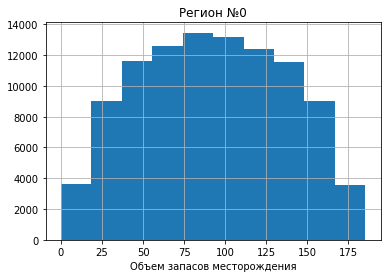

In [9]:
data0['product'].hist(bins=10)
plt.title('Регион №0')
plt.xlabel('Объем запасов месторождения')
plt.show()

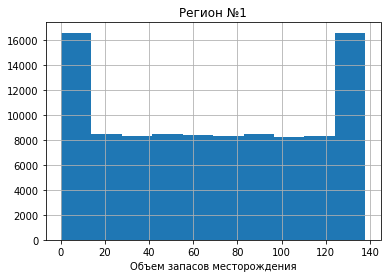

In [10]:
data1['product'].hist(bins=10)
plt.title('Регион №1')
plt.xlabel('Объем запасов месторождения')
plt.show()

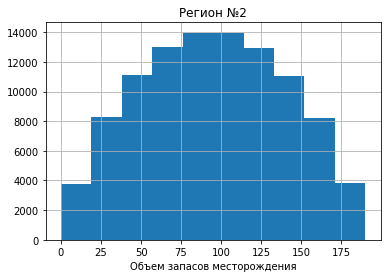

In [11]:
data2['product'].hist(bins=10)
plt.title('Регион №2')
plt.xlabel('Объем запасов месторождения')
plt.show()

### На первой и третьей гистограмме соответствующим региону 0 и 2 видно нормальное распределение, на второй гистограмме региона 1 показано равномерное распределение за исключением минимальных и максимальных запасов - резкое увеличение количества месторождений с такими показателями


### Подготовим данные для обучения модели. Мы замечаем, что значения id бесполезны для нас. Таким образом, мы можем удалить их из данных. (сохраним их в отдельной переменной для возможности использования в будующем)

In [12]:
id_data0 = data0['id']
id_data1 = data1['id']
id_data2 = data2['id']
data0 = data0.drop(['id'], axis=1)
data1 = data1.drop(['id'], axis=1)
data2 = data2.drop(['id'], axis=1)

# 2. Обучение и проверка модели

### Выделим из общих таблиц признаки и целевой признак

In [13]:
target_data0 = data0['product']
target_data1 = data1['product']
target_data2 = data2['product']
features_data0 = data0.drop(['product'], axis=1)
features_data1 = data1.drop(['product'], axis=1)
features_data2 = data2.drop(['product'], axis=1)

###  Разделим на обучающую (train)  и валидационную (valid) выборки в соотношении 75:25

In [14]:
features_train0, features_valid0, target_train0, target_valid0 = train_test_split(features_data0, target_data0, test_size=0.25, 
                                                                              random_state=12345 )
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(features_data1, target_data1, test_size=0.25, 
                                                                              random_state=12345 )
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(features_data2, target_data2, test_size=0.25, 
                                                                              random_state=12345 )

### Обучим модели для каждого региона

In [15]:
model_0 = LinearRegression()
model_0.fit(features_train0, target_train0)
predicted_valid_0 = model_0.predict(features_valid0)

In [16]:
model_1 = LinearRegression()
model_1.fit(features_train1, target_train1)
predicted_valid_1 = model_1.predict(features_valid1)

In [17]:
model_2 = LinearRegression()
model_2.fit(features_train2, target_train2)
predicted_valid_2 = model_2.predict(features_valid2)

### Подсчитаем средний запас сырья и RMSE моделей по регионам

In [18]:
mse_0 = mean_squared_error(target_valid0, predicted_valid_0)
rmse_0 = mse_0 ** 0.5
mean_0 = data0['product'].mean()
print('Данные по региону № 0')
print('Средний запас сырья = {:.2F}'.format(mean_0),'тыс. баррель')
print('RMSE модели = {:.2f}'.format(rmse_0))

Данные по региону № 0
Средний запас сырья = 92.50 тыс. баррель
RMSE модели = 37.58


In [19]:
mse_1 = mean_squared_error(target_valid1, predicted_valid_1)
rmse_1 = mse_1 ** 0.5
mean_1 = data1['product'].mean()
print('Данные по региону № 1')
print('Средний запас сырья = {:.2F}'.format(mean_1),'тыс. баррель')
print('RMSE модели = {:.2f}'.format(rmse_1))

Данные по региону № 1
Средний запас сырья = 68.83 тыс. баррель
RMSE модели = 0.89


In [20]:
mse_2 = mean_squared_error(target_valid2, predicted_valid_2)
rmse_2 = mse_2 ** 0.5
mean_2 = data2['product'].mean()
print('Данные по региону № 2')
print('Средний запас сырья = {:.2F}'.format(mean_2),'тыс. баррель')
print('RMSE модели = {:.2f}'.format(rmse_2))

Данные по региону № 2
Средний запас сырья = 95.00 тыс. баррель
RMSE модели = 40.03


### На основании полученных данных можно сделать следующий вывод: Наибольший средний запас сырья в размере 95 находится в регионе № 2 , далее регион № 0 со средним запасом сырья равным 92.5 и наименьший запас сырья имеет регион № 1 - 68,8. Метрика качества mse в исходных единицах измерения - RMSE (корень от среднеквадратичной ошибки) составил: по регионам №0 = 37,5 №1 = 0,89 , №2 = 40

# 3. Подготовка к расчёту прибыли

### Для расчета прибыли сохраним необходимые зачения 

In [21]:
# сохраним стоимость бурения одной скважины
DRILLING_PRISE = 50000000
# Бюджет на разработку месторождений
BUDGET = 10000000000
# прибыль с одного барреля сырья
PROFIT_BARREL = 4500
# количество иследований при разведке региона
COUNT_POINT = 500


# 4. Расчёт прибыли и рисков 

### Произведем подсчет минимального среднего объема сырья в месторождениях региона, достаточный для его разработки

### Предположим, что минимальный средний объем сырья в месторождениях региона, достаточный для его разработки должен быть не ниже уровня при котором прибыль по крайней мере сравняется с инвестициями в разработку месторождений. Иными словами разница между бюджетом на разработку месторождений и прибылью от добытых баррелей сырья будет нулевой. Прибыль будет слаживатся из количества пробуренных скважин и среднего объема сырья. Количество скважин равняется сумме бюджета поделеной на стоимость одной скважины. 

In [22]:
count_oil_well = BUDGET / DRILLING_PRISE
min_mean_volume = BUDGET / (count_oil_well * PROFIT_BARREL )
print('Минимальный средний объем сырья = {:.2f}'.format(min_mean_volume/1000), "тыс. баррель")

Минимальный средний объем сырья = 11.11 тыс. баррель


### Исходя из сделаного предположения получен результат минимального среднего объемы сырья в месторождениях региона должен быть более 11,11 тыс.баррелей. Запасы во всех трех регионах превышают минимальный уровень.

### Создадим функцию для расчета прибыли по набору отобранных месторождений и предсказаний модели

In [23]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (( selected.sum() * 1000 * PROFIT_BARREL) - (DRILLING_PRISE * count)) / 1000000000 # делением примедем к милрд. руб.

### Расчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков на уровне 2.5% для региона №0

In [24]:
probabilities = pd.Series(np.array(predicted_valid_0))
target_valid0 = target_valid0.reset_index(drop=True) 
state = np.random.RandomState(12345)
values_0 = []
for i in range(1000):
    target_subsample = target_valid0.sample(n=500, replace=True, random_state=state) ### ошибка
    probs_subsample = probabilities[target_subsample.index]  
    values_0.append(revenue(target_subsample, probs_subsample, 200))

In [25]:
values = pd.Series(values_0) 
confidence_interval = st.t.interval(0.95, len(values_0)-1, loc=values.mean(), scale=st.sem(values))
mean = values.mean() 
lower = st.percentileofscore(values, 0) # расчет доли отрицательных значений прибыли
print('Данные по региону № 0')
print("Средняя выручка: {:.2f}" .format(mean), 'млрд.руб')
print("95%-доверительный интервал: ", confidence_interval, 'млрд.руб')
print('Риск убытков =', lower, '%')

Данные по региону № 0
Средняя выручка: 94.26 млрд.руб
95%-доверительный интервал:  (94.087322070687, 94.43144846752487) млрд.руб
Риск убытков = 0.0 %


### Расчитаем среднюю прибыл, 95%-й доверительный интервал и риск убытков на уровне 2.5% для региона №1

In [26]:
probabilities = pd.Series(np.array(predicted_valid_1))
target_valid1 = target_valid1.reset_index(drop=True)
state = np.random.RandomState(12345)
values_1 = []
for i in range(1000):
    target_subsample = target_valid1.sample(n=500, replace=True, random_state=state) 
    probs_subsample = probabilities[target_subsample.index]  
    values_1.append(revenue(target_subsample, probs_subsample, 200))

In [27]:
values = pd.Series(values_1) 
confidence_interval = st.t.interval(0.95, len(values)-1, loc=values.mean(), scale=st.sem(values))
mean = values.mean()
lower = st.percentileofscore(values, 0)
print('Данные по региону № 1')
print("Средняя выручка: {:.2f}" .format(mean), 'млрд.руб')
print("95%-доверительный интервал: ", confidence_interval, 'млрд.руб')
print('Риск убытков =', lower, '%')

Данные по региону № 1
Средняя выручка: 95.15 млрд.руб
95%-доверительный интервал:  (95.01621476176322, 95.28824070710257) млрд.руб
Риск убытков = 0.0 %


### Расчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков на уровне 2.5% для региона №2

In [28]:
probabilities = pd.Series(np.array(predicted_valid_2))
target_valid2 = target_valid2.reset_index(drop=True)
state = np.random.RandomState(12345)
values_2 = []
for i in range(1000):
    target_subsample = target_valid2.sample(n=500, replace=True, random_state=state) ### ошибка: target_valid2
    probs_subsample = probabilities[target_subsample.index]  
    values_2.append(revenue(target_subsample, probs_subsample, 200))

In [29]:
values = pd.Series(values_2) 
confidence_interval = st.t.interval(0.95, len(values)-1, loc=values.mean(), scale=st.sem(values))
mean = values.mean()
lower = st.percentileofscore(values, 0)
print('Данные по региону № 2')
print("Средняя выручка: {:.2f}" .format(mean), 'млрд.руб')
print("95%-доверительный интервал: ", confidence_interval, 'млрд.руб')
print('Риск убытков =', lower, '%')

Данные по региону № 2
Средняя выручка: 94.35 млрд.руб
95%-доверительный интервал:  (94.17453552041358, 94.52563173524153) млрд.руб
Риск убытков = 0.0 %


### Проведя иследование получили следующие результаты:
### Наибольшая средняя выручка получена для региона №1 и составила 95.15 млрд. рублей (с 95% доверительным интервалом 95.01 - 95.28) , следующий регион по величине средней выручки 94.35 млн. рублей №2 (с 95% доверительным интервалом 94.17 - 94.52)  и наименьший показатель имеет регион №0 = 94.26 млрд. рублей (с 95% доверительным интервалом 94.08 - 94.43) . 
### При этом риск убытков на уровне  2,5%, показывающий долю скважин с отрицательной прибылью,  для всех регионов был получен равным нулевому значению.

## Общий вывод

### Рассматривая результаты исследований можно заметить, что ни один регион не показал риск убытков выше 2,5% и это позволяет рассматривать все три региона для разработки месторождений. При этом наибольший средний запас сырья в размере 73.37 находится в регионе № 2 , далее регион № 0 со средним запасом сырья равным 72.73 и наименьший запас сырья имеет регион № 1 - 68,8. Метрика качества построиных моделией - RMSE (корень от среднеквадратичной ошибки) составил: по регионам №0 = 37,5 №1 = 0,89 , №2 = 40. Наибольшая средняя выручка получена для региона №1 и составила 95.15 млрд. рублей, следующий регион, по величине средней выручки 94.35 млн. рублей, №2 и наименьший показатель имеет регион №0 = 94.26 млрд. рублей.                        
### Исходя из наибольшей средней прибыли можно предложитть для разработки месторождений регион №1.